# Euclidean Heat Kernel - Diffusion & Denoising

In this notebook, we will show how we can
- use the exact score function for the Euclidean heat kernel to reverse the forward diffusion process
- train a neural network to approximate this score function and replicate the same denoising procedure
  
The idea is that we can have a direct comparison between our ML results and the analytical results, since we know the score function for the heat kernel exactly.

*Note: In more practical applications when we start with non-trivial 'training data' (i.e., give the heat equation initial conditions), we do not know the true score function for all time.*

## Setup

In [1]:
# General imports
import numpy as np
import torch
import math

import tqdm.auto as tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# Imports from our repo
import sys
sys.path.insert(0, '..')  # repo source code

from src.diffusion import VarianceExpandingDiffusion
from src.heat import eucl_score_hk
from src.utils import grab, wrap
from src.devices import set_device, get_device, summary

In [3]:
set_device('cuda', 0)
print(summary())

Using device: cuda:0 (NVIDIA GH200 120GB) with dtype: torch.float32


## Background: Euclidean Diffusion

Diffusion is a stochastic process described by $$dx = g(t) dW$$ that corresponds to the heat equation: $$\partial_t u(x, t) = \frac{g(t)^2}{2} \Delta u(x, t),$$ where $g^2$ is a postive, time-dependent scalar quantity we call the *diffusivity*. For *variance-expanding* diffusion, the diffusivity takes the form 

$$g(t) = \sigma^t,$$

for constant $\sigma > 0$. 

In [4]:
def variance_expanding_std(sigma, t):
    return ((sigma ** (2*t) - 1) / (2 * math.log(sigma)))**0.5

The differential operator $\Delta$ is the Laplace-Beltrami operator on whatever ambient space the samples $x$ occupy. In Euclidean space, $x \in \mathbb{R}^n$, $\Delta$ is just the familiar Laplacian given by $\Delta := \sum_{i=1}^n \partial_i^2$. In particuar, for a single, real-valued degree of freedom (with constant unit diffusivity), the heat equation is $$\partial_t u = \partial_x^2 u,$$ and the fundamental solution (Green's function / propagator) for this PDE is called the *Heat Kernel* and is given by $$K(x, t) = \frac{1}{\sqrt{2\pi\sigma(t)^2}}e^{-\frac{x^2}{2\sigma(t)^2}},$$ where $\sigma(t)$ is the marginal standard deviation, given by

$$\sigma(t)^2 = \int_0^t g(s)^2 ds = \frac{\sigma^{2t} - 1}{2 \log(\sigma)}$$

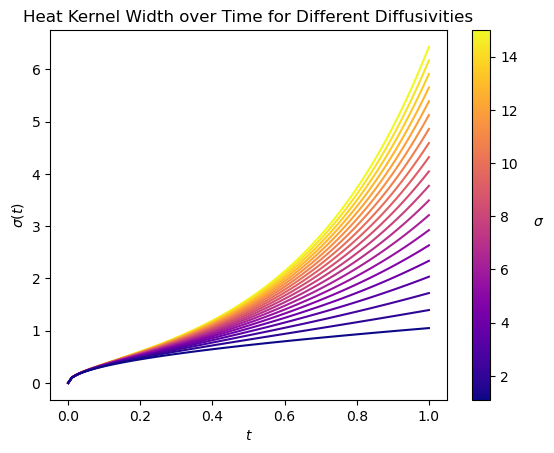

In [5]:
def _visualize_sigma_t():
    
    fig, ax = plt.subplots(1, 1)
    ts = np.linspace(0, 1.0, 100)
    sigmas = np.linspace(1.1, 15, 20)
    
    cmap = mpl.colormaps.get_cmap('plasma')
    norm = mpl.colors.Normalize(vmin=sigmas[0], vmax=sigmas[-1])  # Use same normalization
    
    for sigma in reversed(sigmas):
        color = cmap(norm(sigma))  # normalize sigma consistently
        ax.plot(ts, variance_expanding_std(sigma, ts), color=color)
    
    # Colorbar
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # dummy array
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label(r'$\sigma$', rotation=0, labelpad=15)
    
    ax.set_xlabel('$t$')
    ax.set_ylabel(r'$\sigma(t)$')
    ax.set_title('Heat Kernel Width over Time for Different Diffusivities')
    plt.show()


_visualize_sigma_t()

/tmp/ipykernel_1296826/3893506989.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  normalization = 1 / (2*np.pi * width**2)**0.5


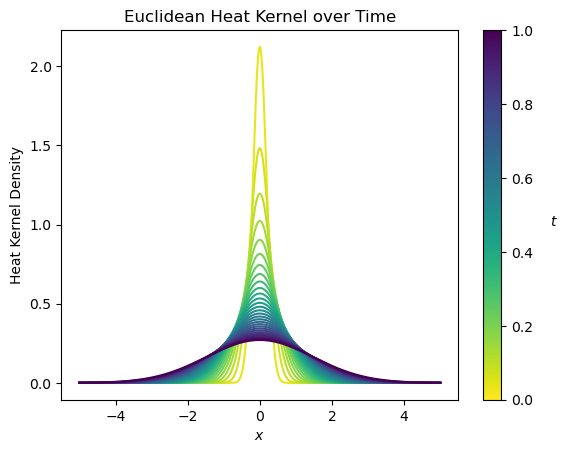

In [6]:
def euclidean_heat_kernel(x, *, width):
    """Computes the Euclidean heat kernel density K(x, t) for `x` at time `t`."""
    normalization = 1 / (2*np.pi * width**2)**0.5
    weight = torch.exp(-x**2 / (2 * width**2))
    return normalization * weight


def _visualize_heat_kernel():
    xs = torch.linspace(-5, 5, 1000)
    sigma = 2.0
    times = np.linspace(0.0, 1.0, 30)

    fig, ax = plt.subplots(1, 1)
    cmap = mpl.cm.viridis_r
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    
    for t in times:
        width = variance_expanding_std(sigma, t)
        color = cmap(norm(t))
        ax.plot(grab(xs), grab(euclidean_heat_kernel(xs, width=width)), color=color)
    
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # required for ScalarMappable
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('$t$', rotation=0, labelpad=15)
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('Heat Kernel Density')
    ax.set_title('Euclidean Heat Kernel over Time')
    fig.show()

_visualize_heat_kernel()

One can easily sample from the Euclidean heat kernel at arbitrary time $t$; since $K(x, t)$ is always a normal distribution, you only need to know the marginal standard deviation at $t$.

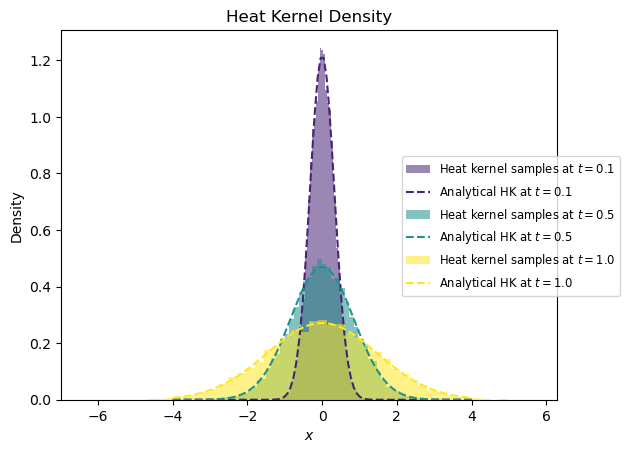

In [7]:
def sample_euclid_hk(batch_size, *, width):
    """Generates `batch_size` samples from the Euclidean Heat kernel."""
    x_t = width * torch.randn((batch_size,))
    return x_t

def _test_sample_hk():
    batch_size = 16384
    xs = torch.linspace(-4, 4, 100)
    sigma = 2.0
    times = [0.1, 0.5, 1.0]
    
    cmap = plt.get_cmap('viridis')
    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('Density')
    for t in times:
        sigma_t = variance_expanding_std(sigma, t)
        xt = sample_euclid_hk(batch_size, width=sigma_t)
        ax.hist(grab(xt), bins=50, density=True, color=cmap(t), alpha=0.55, label=f'Heat kernel samples at $t = {t}$')
        ax.plot(grab(xs), grab(euclidean_heat_kernel(xs, width=sigma_t)), ls='--', color=cmap(t), label=f'Analytical HK at $t = {t}$')
    fig.legend(loc='right', fontsize='small')
    ax.set_title('Heat Kernel Density')
    fig.show()

_test_sample_hk()

It's also easy to simulate the forward process by directly feeding initial data (zero) into our diffuser object:

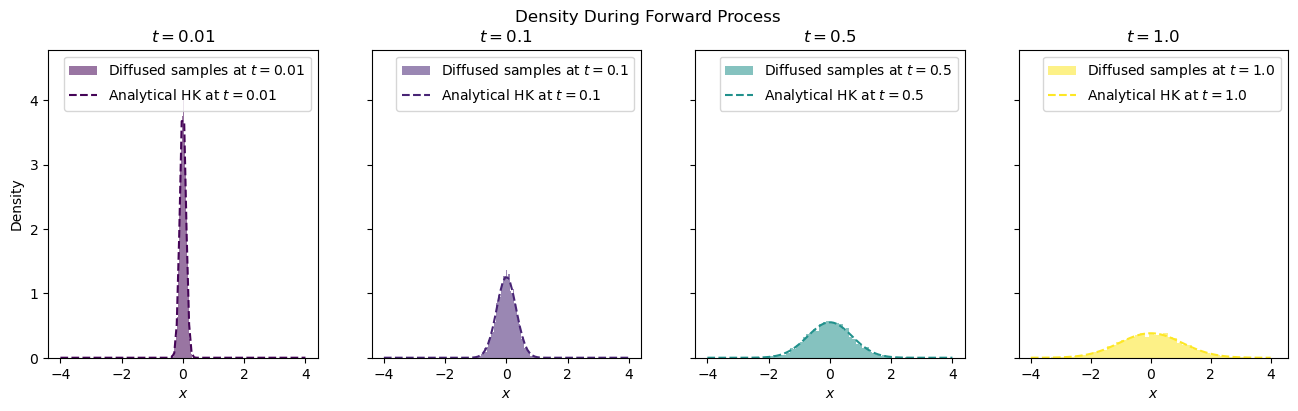

In [8]:
def visualize_euclid_fwd():
    """Simulates forward Euclidean VE diffusion process."""
    batch_size = 4096
    x_0 = torch.zeros((batch_size, 1))
    diffuser = VarianceExpandingDiffusion(sigma=1.1)
    
    xs = torch.linspace(-4, 4, 100)
    times = [0.01, 0.1, 0.5, 1.0]
    cmap = mpl.colormaps.get_cmap('viridis')
    
    fig, axes = plt.subplots(1, len(times), figsize=(4*len(times), 4), sharey=True)
    fig.suptitle('Density During Forward Process')
    axes[0].set_ylabel('Density')
    for t, ax in zip(times, axes):
        # Samples stats should match params of analytical HK
        x_t = diffuser(x_0, torch.tensor(t).repeat(batch_size))
        sigma_t = diffuser.sigma_func(t)
        assert torch.allclose(torch.std(x_t), sigma_t, atol=5e-2), \
            f'StDev of samples {torch.std(x_t).item():.4f} does not match marginal HK StDev {sigma_t:.4f}'
        
        # Visualize forward process over time
        ax.set_title(f'$t = {t}$')
        ax.set_xlabel('$x$')
        ax.hist(grab(x_t), bins=50, density=True, color=cmap(t), alpha=0.55, label=f'Diffused samples at $t = {t}$')
        ax.plot(grab(xs), grab(euclidean_heat_kernel(xs, width=sigma_t)), ls='--', color=cmap(t), label=f'Analytical HK at $t = {t}$')
        ax.legend()
    fig.show()

visualize_euclid_fwd()

## Denoising with the Exact Score Function

The analytical score function for the Euclidean heat kernel is simply given by:

$$s(x, t) := \partial_x \log K(x, t) = -\frac{x}{\sigma(t)^2}$$

which can be used to solve either the ODE or SDE in reverse time: $$d\tilde{x} = -g(t)^2 s(x, t)dt + g(t) dW$$ $$d\tilde{x} = -\frac{1}{2}g(t)^2 s(x, t)dt$$

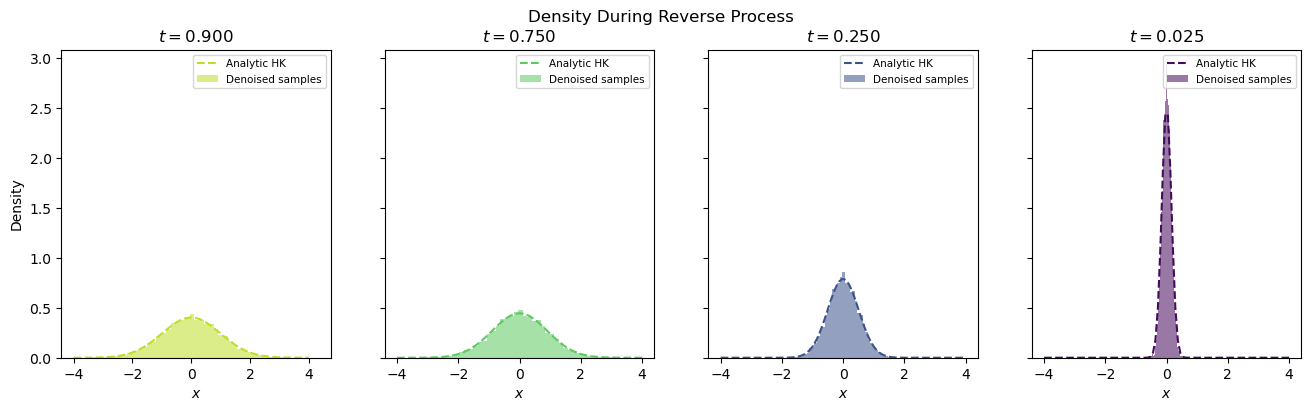

In [9]:
def denoise_backward(x_1, diffuser, num_steps=200, solver_type='ODE'):
    dt = 1 / num_steps
    t = 1.0
    x_t = x_1.clone()

    trajectories = []
    for step in range(num_steps):
        sigma_t = diffuser.sigma_func(t)
        g_t = diffuser.noise_coeff(t)
        score = eucl_score_hk(x_t, width=sigma_t)
        
        # Integration step
        if solver_type == 'ODE':
            x_t = x_t + 0.5 * g_t**2 * score * dt
        elif solver_type == 'SDE':
            x_t = x_t + 0.5*g_t**2 * score * dt + g_t * torch.rand_like(x_t) * dt**0.5  # TODO: debug
        else:
            raise NotImplementedError(f'Integration method {solver_type} not supported')
        t -= dt
        trajectories.append(x_t)
    return x_t, trajectories


def _test_denoise():
    batch_size = 8192
    diffuser = VarianceExpandingDiffusion(sigma=1.1)
    x_1 = sample_euclid_hk(batch_size, width=diffuser.sigma_func(1.0))
    
    num_steps = 200
    x_0, trajectories = denoise_backward(x_1, diffuser, num_steps)
    
    cmap = mpl.colormaps.get_cmap('viridis')
    xs = torch.linspace(-4, 4, 100)
    steps = [20, 50, 150, 195]
    
    fig, axes = plt.subplots(1, len(steps), figsize=(4*len(steps), 4), sharey=True)
    fig.suptitle('Density During Reverse Process')
    axes[0].set_ylabel('Density')
    for ax, step in zip(axes, steps):
        # Check that stats of denoised samples match params of analytical HK
        t = 1 - step/num_steps
        x_t = trajectories[step]
        sigma_t = diffuser.sigma_func(t)
        #assert torch.allclose(torch.std(x_t), sigma_t, atol=5e-2), \
        #    f'StDev of samples {torch.std(x_t).item():.4f} does not match marginal HK StDev {sigma_t:.4f}'
        
        # Display reverse process plots
        ax.set_title(f'$t = {t:.3f}$')
        ax.set_xlabel('$x$')
        hk = euclidean_heat_kernel(xs, width=sigma_t)
        hk /= hk.sum() * (xs[1] - xs[0])
        ax.plot(grab(xs), grab(hk), ls='--', color=cmap(t), label=f'Analytic HK')
        ax.hist(grab(x_t), bins=50, color=cmap(t), alpha=0.55, density=True, label=f'Denoised samples')
        ax.legend(fontsize=7.5)
    fig.show()

_test_denoise()

## Denoising with a Trained Score Network

First we build a very simple MLP as our score network, which will input both $x$ and $t$ (for now, no special embeddings for $t$, just handle the raw time as-is)

In [10]:
class ScoreNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, 8),  # data & time = 1 + 1 dims
            torch.nn.SiLU(),
            torch.nn.Linear(8, 8),
            torch.nn.SiLU(),
            torch.nn.Linear(8, 8),
            torch.nn.SiLU(),
            torch.nn.Linear(8, 1))

    def forward(self, x_t, t):
        if len(t.shape) == 1:
            t = t.unsqueeze(-1)
        return self.net(torch.cat([x_t, t], dim=-1))


def _test_score_net():
    batch_size = 100
    x = torch.randn((batch_size, 1))
    t = torch.rand((batch_size,))
    s_t = ScoreNet()(x, t)
    print('x shape:', x.shape)
    print('t shape:', t.shape)
    print('s_t shape:', s_t.shape)
    assert s_t.shape == x.shape, \
        'Score output should have same shape as input'
    print('[PASSED]')

_test_score_net()

x shape: torch.Size([100, 1])
t shape: torch.Size([100])
s_t shape: torch.Size([100, 1])
[PASSED]


Define the conventional **score matching** loss

In [11]:
def score_matching_loss(x_0, diffuser, score_net, tol=1e-5):
    t = torch.rand((x_0.size(0),))
    t = tol + (1 - tol) * t  # stability near endpoints
    
    # Diffuse x_0 -> x_t, get s(x_t, t)
    x_t = diffuser(x_0, t.squeeze())
    sigma_t = diffuser.sigma_func(t)[:, None]
    score = score_net(x_t, t) / sigma_t  # rescale score net
    #NOTE: make sure shapes line up!! Can get silent side-effects
    
    # s(x_t, t) should approximate grad log N(x_t; x_0, sigma_t^2)
    eps = (x_t - x_0) / sigma_t
    loss = (sigma_t * score + eps)**2  # weight factor of sigma(t)^2 for stability
    return torch.mean(loss)

Now do the training

In [12]:
# Diffusion params
sigma = 1.1
diffuser = VarianceExpandingDiffusion(sigma)
score_net = ScoreNet()

# Training hyperparams
lr = 1e-3
epochs = 1000
batch_size = 1024
optimizer = torch.optim.Adam(params=score_net.parameters(), lr=lr)

# Training loop
x_0 = torch.zeros((batch_size, 1))
losses = []
for epoch in tqdm.tqdm(range(epochs)):
    optimizer.zero_grad()
    loss = score_matching_loss(x_0, diffuser, score_net)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch}/{epochs} | Loss = {loss.item():.6f}')
    losses.append(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0/1000 | Loss = 1.057358
Epoch 1/1000 | Loss = 1.091253
Epoch 2/1000 | Loss = 1.052320
Epoch 3/1000 | Loss = 1.020327
Epoch 4/1000 | Loss = 1.041500
Epoch 5/1000 | Loss = 1.082570
Epoch 6/1000 | Loss = 0.999397
Epoch 7/1000 | Loss = 0.995223
Epoch 8/1000 | Loss = 1.055035
Epoch 9/1000 | Loss = 1.125879
Epoch 10/1000 | Loss = 1.065789
Epoch 11/1000 | Loss = 0.950205
Epoch 12/1000 | Loss = 1.065474
Epoch 13/1000 | Loss = 1.021789
Epoch 14/1000 | Loss = 0.987922
Epoch 15/1000 | Loss = 1.070330
Epoch 16/1000 | Loss = 0.986633
Epoch 17/1000 | Loss = 1.032514
Epoch 18/1000 | Loss = 0.992888
Epoch 19/1000 | Loss = 0.981737
Epoch 20/1000 | Loss = 1.067900
Epoch 21/1000 | Loss = 0.992239
Epoch 22/1000 | Loss = 1.093755
Epoch 23/1000 | Loss = 1.087552
Epoch 24/1000 | Loss = 1.016485
Epoch 25/1000 | Loss = 1.080896
Epoch 26/1000 | Loss = 0.986604
Epoch 27/1000 | Loss = 1.007815
Epoch 28/1000 | Loss = 0.995157
Epoch 29/1000 | Loss = 1.003791
Epoch 30/1000 | Loss = 1.042564
Epoch 31/1000 | Lo

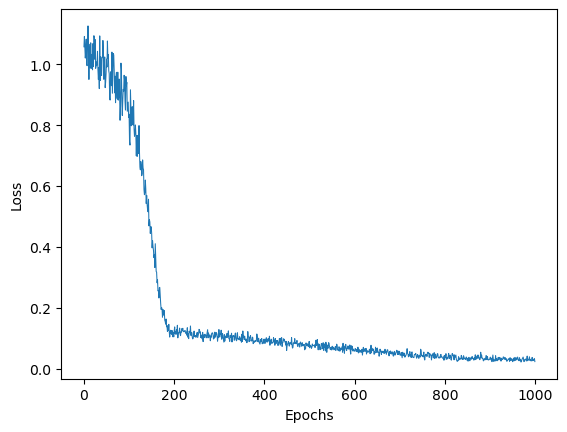

In [13]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.plot(losses, lw=0.75)
fig.show()

To generate new samples, we define a function to sample from the diffusion model posterior using our trained score network:

In [14]:
@torch.no_grad()
def euler_sampler(x_1, score_net, diffuser, num_steps=200, solver_type='ODE', verbose=False):
    score_net.eval()
    batch_size = x_1.size(0)
    
    trajectories = []
    dt = 1 / num_steps
    x_t = x_1.clone()
    t = 1.0
    for step in tqdm.tqdm(range(num_steps)):
        # Get ODE / SDE params
        sigma_t = diffuser.sigma_func(t)
        g_t = diffuser.noise_coeff(t)
        score = score_net(x_t, torch.tensor(t).repeat(batch_size,)) / sigma_t

        # Integration step
        if solver_type == 'ODE':
            x_t = x_t + 0.5 * g_t**2 * score * dt  # ODE Euler step
        elif solver_type == 'SDE':
            x_t = x_t + g_t**2 * score * dt + g_t * torch.rand_like(x_t) * dt**0.5  # SDE step
        else:
            raise NotImplementedError(f'Integration method {solver_type} not supported')
        t -= dt

        # Collect and print metrics
        trajectories.append(x_t)
        if verbose:
            print(f'Step {step}/{num_steps} | x_t = {x_t.mean().item():.6f}')
    return x_t, trajectories

  0%|          | 0/100 [00:00<?, ?it/s]

New x_0: 0.0037321324925869703


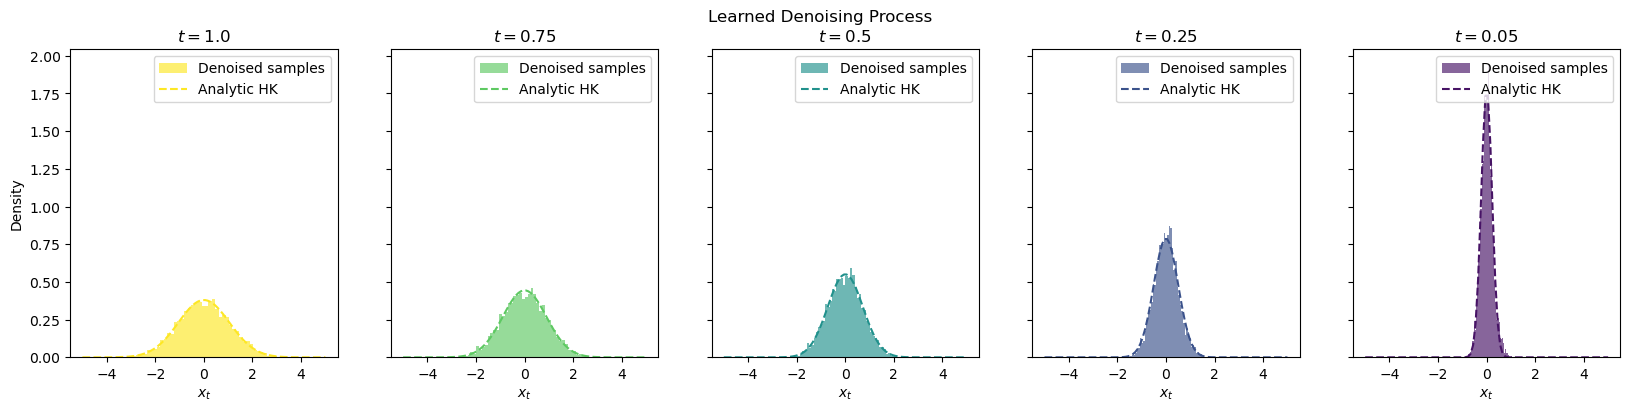

In [15]:
# Initial data: zeros
num_samples = 4096
x_0 = torch.zeros((num_samples, 1))

# Diffuse forward: x_0 -> x_1
sigma = 1.1
diffuser = VarianceExpandingDiffusion(sigma)
x_1 = diffuser(x_0, t=torch.ones((num_samples,)))

# Denoise backward: x_1 -> x_0'
num_steps = 100
x_0, trajectories = euler_sampler(x_1, score_net, diffuser, num_steps, solver_type='ODE')
print('New x_0:', grab(x_0.mean().item()))

# Plot trajectories
times = [1.0, 0.75, 0.5, 0.25, 0.05]
xs = torch.linspace(-5, 5, 100)
cmap = mpl.colormaps.get_cmap('viridis')

fig, axes = plt.subplots(1, len(times), figsize=(4*len(times), 4), sharey=True)
fig.suptitle('Learned Denoising Process')
axes[0].set_ylabel('Density')
for t, ax in zip(times, axes):
    # Denoised samples
    x_t = trajectories[int(num_steps * (1 - t))]
    ax.hist(grab(x_t), bins=50, density=True, color=cmap(t), alpha=0.65, label='Denoised samples')

    # Analytical heat kernel
    hk = euclidean_heat_kernel(xs, width=diffuser.sigma_func(t))
    hk /= hk.sum() * (xs[1] - xs[0])
    ax.plot(grab(xs), grab(hk), color=cmap(t), ls='--', label='Analytic HK')
    ax.set_xlabel(r'$x_t$')
    ax.set_title(f'$t = {t}$')
    ax.legend()
fig.show()

### Include time embedding

What if we use time embedding in our score network? Now we enable the score net to learn a good feature embeddings for the time as well.

In [16]:
class GaussianFourierProjection(torch.nn.Module):
    def __init__(self, embed_dim, scale=30.0):
        super().__init__()

        weights = torch.randn(embed_dim // 2) * scale
        self.W = torch.nn.Parameter(weights, requires_grad=False)

    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :]

        sinx = torch.sin(2*np.pi * x_proj)
        cosx = torch.cos(2*np.pi * x_proj)

        return torch.cat([sinx, cosx], dim=-1)


def _test_embedding():
    print('[Testing GaussianFourierProjection...]')
    batch_size = 5
    t = torch.rand((batch_size,))
    embed_dim = 64
    embedder = GaussianFourierProjection(embed_dim)
    t_embed = embedder(t)
    assert t_embed.shape == (batch_size, embed_dim), \
        '[FAILED: embedded times must have shape [batch_size, embed_dim]]'
    print('[PASSED]')

_test_embedding()

[Testing GaussianFourierProjection...]
[PASSED]


In [17]:
class TimeEmbeddedScoreNet(torch.nn.Module):
    def __init__(self, hidden_dim, embed_dim):
        super().__init__()
        self.time_embedder = torch.nn.Sequential(  # embeds times
            GaussianFourierProjection(embed_dim),
            torch.nn.Linear(embed_dim, hidden_dim),
            torch.nn.SiLU(),
        )
        self.encoder = torch.nn.Sequential(  # encodes data
            torch.nn.Linear(1, hidden_dim),
        )
        self.decoder = torch.nn.Sequential(  # decodes data + times
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_dim, 1)
        )
    def forward(self, x_t, t):
        t_emb = self.time_embedder(t)  # [B] -> [B, E] -> [B, H]
        x_enc = self.encoder(x_t)  # [B, 1] -> [B, H]
        y = x_enc + t_emb  # additive embedding [B, H]
        return self.decoder(y)


def _test_score_net():
    batch_size = 100
    x = torch.randn((batch_size, 1))
    t = torch.rand((batch_size,))
    
    s_t = TimeEmbeddedScoreNet(hidden_dim=8, embed_dim=64)(x, t)
    print('x shape:', x.shape)
    print('t shape:', t.shape)
    print('s_t shape:', s_t.shape)
    assert s_t.shape == x.shape, \
        'Score output should have same shape as input'
    print('[PASSED]')


_test_score_net()

x shape: torch.Size([100, 1])
t shape: torch.Size([100])
s_t shape: torch.Size([100, 1])
[PASSED]


In [18]:
# Diffusion params
sigma = 1.1
diffuser = VarianceExpandingDiffusion(sigma)

# Score network
hidden_dim = 8
embed_dim = 256
score_net = TimeEmbeddedScoreNet(hidden_dim, embed_dim)

# Training hyperparams
lr = 1e-3
epochs = 1000
batch_size = 1024
optimizer = torch.optim.Adam(params=score_net.parameters(), lr=lr)

# Training loop
x_0 = torch.zeros((batch_size, 1))
losses = []
for epoch in tqdm.tqdm(range(epochs)):
    optimizer.zero_grad()
    loss = score_matching_loss(x_0, diffuser, score_net)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch}/{epochs} | Loss = {loss.item():.6f}')
    losses.append(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0/1000 | Loss = 1.725537
Epoch 1/1000 | Loss = 1.380572
Epoch 2/1000 | Loss = 1.485660
Epoch 3/1000 | Loss = 1.635064
Epoch 4/1000 | Loss = 1.538125
Epoch 5/1000 | Loss = 1.676240
Epoch 6/1000 | Loss = 1.613637
Epoch 7/1000 | Loss = 1.482462
Epoch 8/1000 | Loss = 1.497928
Epoch 9/1000 | Loss = 1.446830
Epoch 10/1000 | Loss = 1.498380
Epoch 11/1000 | Loss = 1.546816
Epoch 12/1000 | Loss = 1.532034
Epoch 13/1000 | Loss = 1.480880
Epoch 14/1000 | Loss = 1.408983
Epoch 15/1000 | Loss = 1.621845
Epoch 16/1000 | Loss = 1.439408
Epoch 17/1000 | Loss = 1.523628
Epoch 18/1000 | Loss = 1.474900
Epoch 19/1000 | Loss = 1.558283
Epoch 20/1000 | Loss = 1.437850
Epoch 21/1000 | Loss = 1.513673
Epoch 22/1000 | Loss = 1.391972
Epoch 23/1000 | Loss = 1.393556
Epoch 24/1000 | Loss = 1.393430
Epoch 25/1000 | Loss = 1.501700
Epoch 26/1000 | Loss = 1.512249
Epoch 27/1000 | Loss = 1.361219
Epoch 28/1000 | Loss = 1.376299
Epoch 29/1000 | Loss = 1.300109
Epoch 30/1000 | Loss = 1.432317
Epoch 31/1000 | Lo

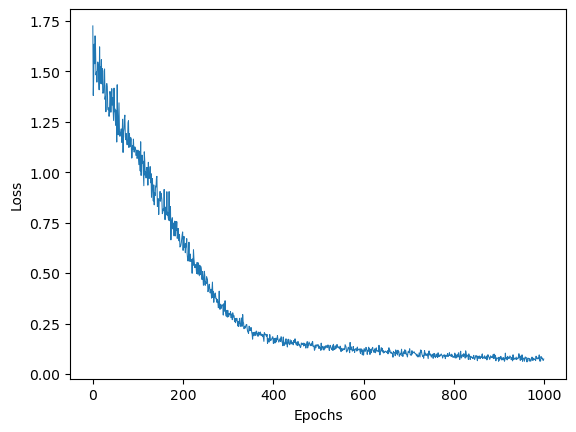

In [19]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.plot(losses, lw=0.75)
fig.show()

So the loss curve definitely has a different shape, but doesn't quite seem to converge to as low of a value...

Let's generate new samples again:

  0%|          | 0/100 [00:00<?, ?it/s]

New x_0: 0.0007338922005146742


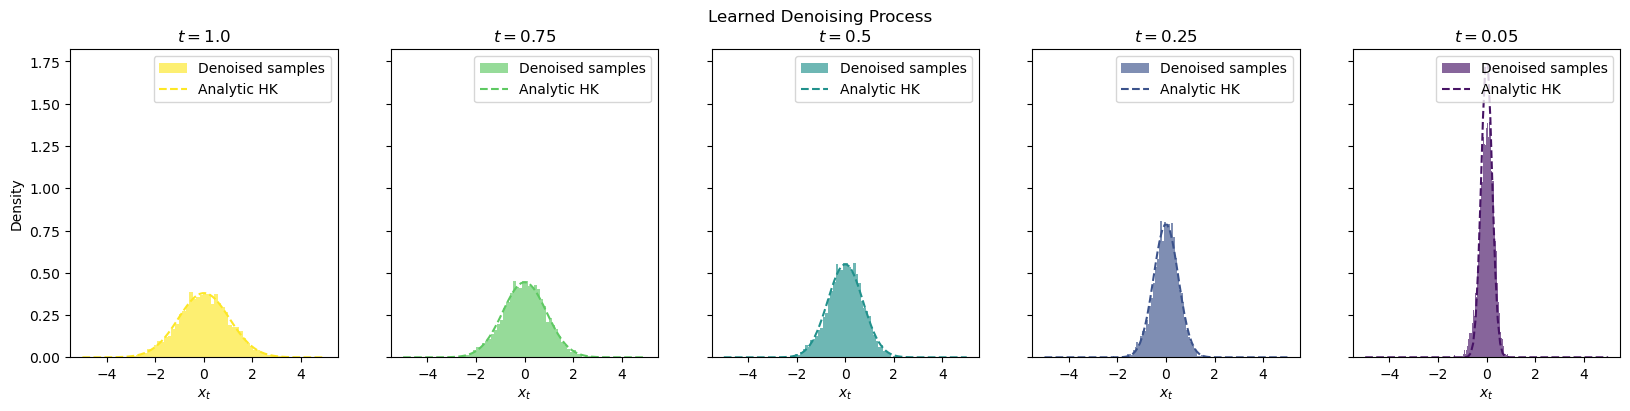

In [20]:
# Initial data: zeros
num_samples = 4096
x_0 = torch.zeros((num_samples, 1))

# Diffuse forward: x_0 -> x_1
sigma = 1.1
diffuser = VarianceExpandingDiffusion(sigma)
x_1 = diffuser(x_0, t=torch.ones((num_samples,)))

# Denoise backward: x_1 -> x_0'
num_steps = 100
x_0, trajectories = euler_sampler(x_1, score_net, diffuser, num_steps, solver_type='ODE')
print('New x_0:', grab(x_0.mean().item()))

# Plot trajectories
times = [1.0, 0.75, 0.5, 0.25, 0.05]
xs = torch.linspace(-5, 5, 100)
cmap = mpl.colormaps.get_cmap('viridis')

fig, axes = plt.subplots(1, len(times), figsize=(4*len(times), 4), sharey=True)
fig.suptitle('Learned Denoising Process')
axes[0].set_ylabel('Density')
for t, ax in zip(times, axes):
    # Denoised samples
    x_t = trajectories[int(num_steps * (1 - t))]
    ax.hist(grab(x_t), bins=50, density=True, color=cmap(t), alpha=0.65, label='Denoised samples')

    # Analytical heat kernel
    hk = euclidean_heat_kernel(xs, width=diffuser.sigma_func(t))
    hk /= hk.sum() * (xs[1] - xs[0])
    ax.plot(grab(xs), grab(hk), color=cmap(t), ls='--', label='Analytic HK')
    ax.set_xlabel(r'$x_t$')
    ax.set_title(f'$t = {t}$')
    ax.legend()
fig.show()

Seems like the performance is, at best, no better than without time embedding. Maybe this example is simple enough that just inputting raw times is sufficiently expressive to recover the heat kernel on a single d.o.f?